## 1. Environment Setup & GPU Verification

In [1]:
import os, sys, json, random
from pathlib import Path
import numpy as np
import pandas as pd

import torch
import matplotlib.pyplot as plt

print("Python:", sys.version.split()[0])
print("Torch :", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


Python: 3.12.12
Torch : 2.8.0+cu126
CUDA available: True
GPU: Tesla T4


## 2. Dataset Paths & Availability Check

In [2]:
CXR_DIR  = Path("/kaggle/input/data")
HAM_DIR  = Path("/kaggle/input/skin-cancer-mnist-ham10000")
BRATS_DIR= Path("/kaggle/input/brats2020-whole-dataset")

for name, p in [("CXR", CXR_DIR), ("HAM", HAM_DIR), ("BRATS", BRATS_DIR)]:
    print(f"{name} exists:", p.exists(), "|", p)

print("\nCXR top items:", sorted([x.name for x in CXR_DIR.iterdir()])[:20])
print("HAM top items:", sorted([x.name for x in HAM_DIR.iterdir()])[:20])
print("BRATS top items:", sorted([x.name for x in BRATS_DIR.iterdir()])[:20])


CXR exists: True | /kaggle/input/data
HAM exists: True | /kaggle/input/skin-cancer-mnist-ham10000
BRATS exists: True | /kaggle/input/brats2020-whole-dataset

CXR top items: ['ARXIV_V5_CHESTXRAY.pdf', 'BBox_List_2017.csv', 'Data_Entry_2017.csv', 'FAQ_CHESTXRAY.pdf', 'LOG_CHESTXRAY.pdf', 'README_CHESTXRAY.pdf', 'images_001', 'images_002', 'images_003', 'images_004', 'images_005', 'images_006', 'images_007', 'images_008', 'images_009', 'images_010', 'images_011', 'images_012', 'test_list.txt', 'train_val_list.txt']
HAM top items: ['HAM10000_images_part_1', 'HAM10000_images_part_2', 'HAM10000_metadata.csv', 'ham10000_images_part_1', 'ham10000_images_part_2', 'hmnist_28_28_L.csv', 'hmnist_28_28_RGB.csv', 'hmnist_8_8_L.csv', 'hmnist_8_8_RGB.csv']
BRATS top items: ['MICCAI_BraTS2020_TrainingData', 'MICCAI_BraTS2020_ValidationData']


## 3. ChestX-ray14: Load CSV & Inspect Structure

In [3]:
cxr_csv = CXR_DIR / "Data_Entry_2017.csv"
train_list = CXR_DIR / "train_val_list.txt"
test_list  = CXR_DIR / "test_list.txt"

print("CXR CSV exists:", cxr_csv.exists(), cxr_csv)
print("train_list:", train_list.exists(), train_list)
print("test_list :", test_list.exists(), test_list)

cxr_df = pd.read_csv(cxr_csv)
print("Rows:", len(cxr_df), "Cols:", cxr_df.shape[1])
display(cxr_df.head(3))
print("\nColumns:", list(cxr_df.columns)[:25])


CXR CSV exists: True /kaggle/input/data/Data_Entry_2017.csv
train_list: True /kaggle/input/data/train_val_list.txt
test_list : True /kaggle/input/data/test_list.txt
Rows: 112120 Cols: 12


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN



Columns: ['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11']


## 4. ChestX-ray14: Label Distribution & Class Imbalance

No Finding            60361
Infiltration          19894
Effusion              13317
Atelectasis           11559
Nodule                 6331
Mass                   5782
Pneumothorax           5302
Consolidation          4667
Pleural_Thickening     3385
Cardiomegaly           2776
Emphysema              2516
Edema                  2303
Fibrosis               1686
Pneumonia              1431
Hernia                  227
dtype: int64

Num unique labels: 15


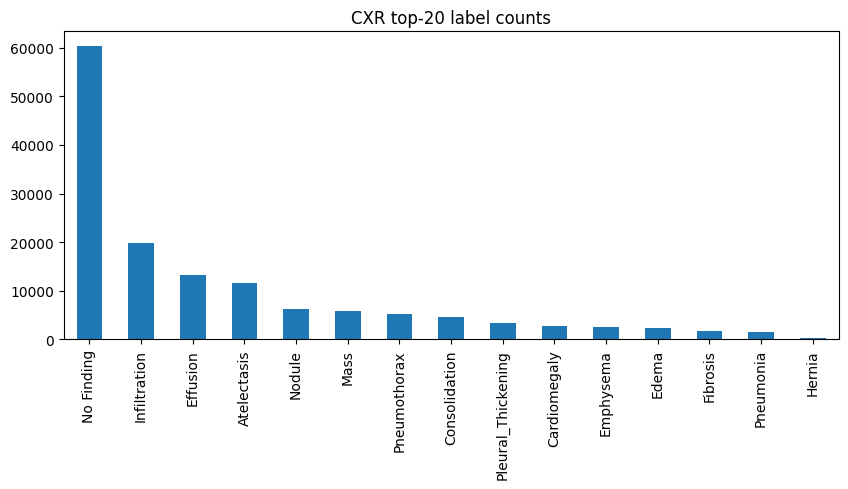

Multi-label rate: 0.18547984302533


In [4]:
# Split labels "A|B|C"
all_labels = cxr_df["Finding Labels"].fillna("No Finding").astype(str).str.split("|")
label_counts = {}
for labs in all_labels:
    for l in labs:
        label_counts[l] = label_counts.get(l, 0) + 1

label_counts = pd.Series(label_counts).sort_values(ascending=False)
display(label_counts.head(20))
print("Num unique labels:", len(label_counts))

plt.figure(figsize=(10,4))
label_counts.head(20).plot(kind="bar")
plt.title("CXR top-20 label counts")
plt.show()

multi_label_rate = (all_labels.apply(len) > 1).mean()
print("Multi-label rate:", float(multi_label_rate))


## 5. ChestX-ray14: Image Location & Visual Samples

Total PNG images found: 112120
Example: /kaggle/input/data/images_003/images/00006199_010.png


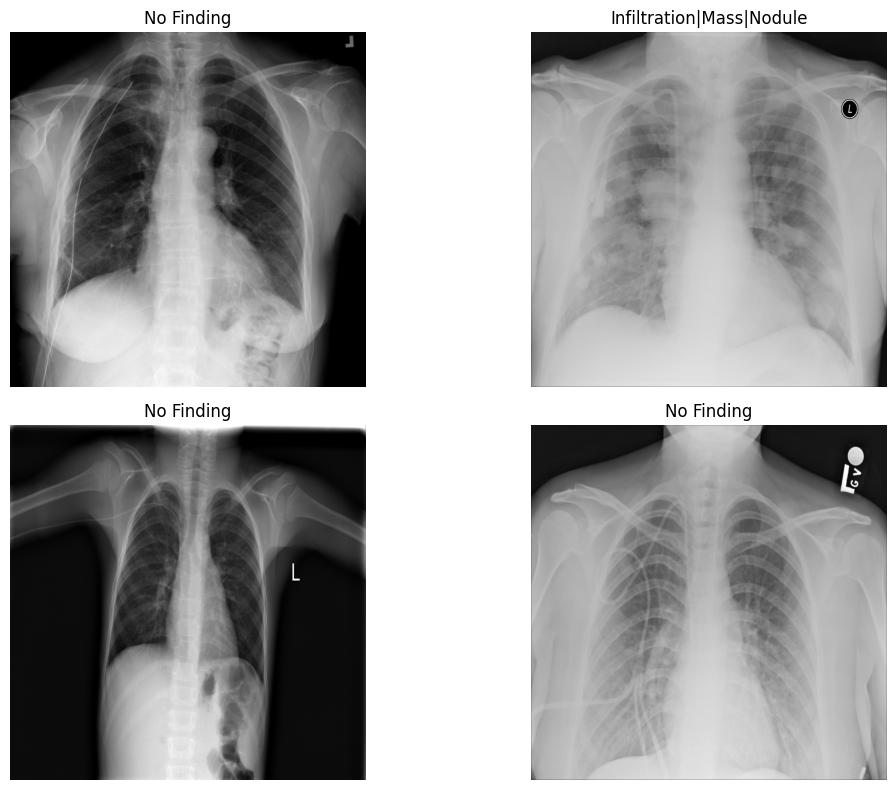

In [5]:
from PIL import Image

# index images folder recursively (fast enough)
img_paths = list(CXR_DIR.rglob("*.png"))
print("Total PNG images found:", len(img_paths))
print("Example:", img_paths[0] if img_paths else None)

# make a map: filename -> full path
cxr_map = {p.name: p for p in img_paths}

# show 4 random samples from CSV that exist on disk
sample = cxr_df.sample(4, random_state=42)
plt.figure(figsize=(12,8))
for i, (_, row) in enumerate(sample.iterrows(), 1):
    fname = row["Image Index"]
    path = cxr_map.get(fname, None)
    plt.subplot(2,2,i)
    if path is None:
        plt.text(0.1,0.5,f"Missing: {fname}", fontsize=12)
        plt.axis("off")
    else:
        img = Image.open(path).convert("L")
        plt.imshow(img, cmap="gray")
        plt.title(row["Finding Labels"])
        plt.axis("off")
plt.tight_layout()
plt.show()


## 6. HAM10000: Load Metadata & Class Distribution

HAM metadata exists: True /kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv
Rows: 10015 Cols: 7


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp



Class counts:


dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

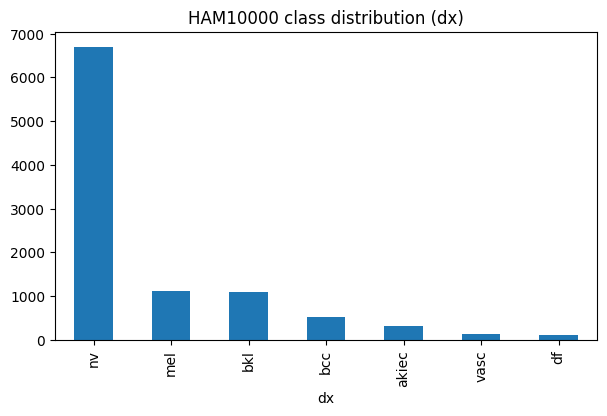

In [6]:
ham_meta = HAM_DIR / "HAM10000_metadata.csv"
print("HAM metadata exists:", ham_meta.exists(), ham_meta)

ham_df = pd.read_csv(ham_meta)
print("Rows:", len(ham_df), "Cols:", ham_df.shape[1])
display(ham_df.head(3))

print("\nClass counts:")
display(ham_df["dx"].value_counts())

plt.figure(figsize=(7,4))
ham_df["dx"].value_counts().plot(kind="bar")
plt.title("HAM10000 class distribution (dx)")
plt.show()


## 7. HAM10000: Image Verification & Class Examples

Total HAM jpg: 20030
Example: /kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028933.jpg


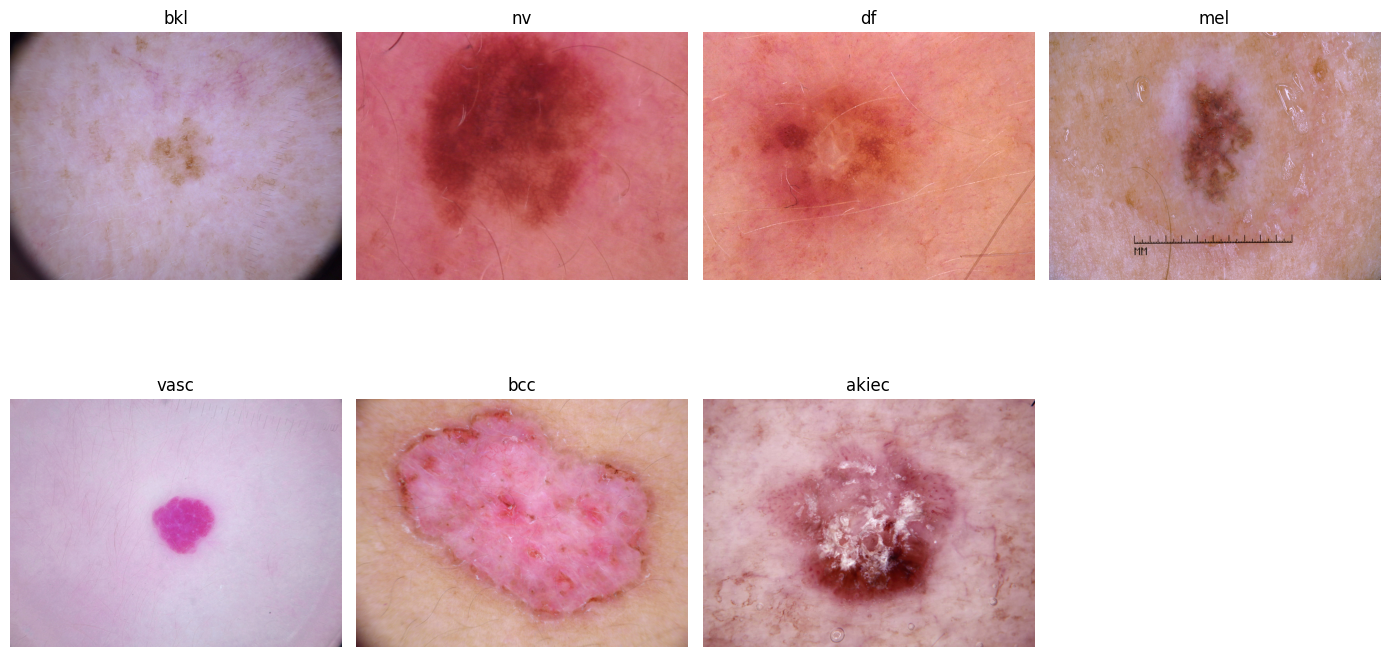

HAM missing image rate: 0.0


In [7]:
from PIL import Image

# find images in both parts
ham_imgs = list(HAM_DIR.rglob("*.jpg"))
print("Total HAM jpg:", len(ham_imgs))
print("Example:", ham_imgs[0] if ham_imgs else None)

ham_map = {p.stem: p for p in ham_imgs}  # image_id -> path

# show 7 images: one per class if possible
classes = ham_df["dx"].unique().tolist()
plt.figure(figsize=(14,8))
k = 0
for cls in classes:
    row = ham_df[ham_df["dx"]==cls].sample(1, random_state=1).iloc[0]
    img_id = row["image_id"]
    path = ham_map.get(img_id, None)
    k += 1
    plt.subplot(2,4,k)
    if path is None:
        plt.text(0.1,0.5,f"Missing {img_id}", fontsize=12)
        plt.axis("off")
    else:
        img = Image.open(path).convert("RGB")
        plt.imshow(img)
        plt.title(cls)
        plt.axis("off")
plt.tight_layout()
plt.show()

# report missing rate
missing = ham_df["image_id"].map(lambda x: x not in ham_map).mean()
print("HAM missing image rate:", float(missing))


## 8. BraTS2020: Explore Directory Structure & Count Subjects

In [8]:
train_root = BRATS_DIR / "MICCAI_BraTS2020_TrainingData" / "MICCAI_BraTS2020_TrainingData"
val_root   = BRATS_DIR / "MICCAI_BraTS2020_ValidationData" / "MICCAI_BraTS2020_ValidationData"

print("Train root exists:", train_root.exists(), train_root)
print("Val root exists  :", val_root.exists(), val_root)

train_subjects = sorted([p for p in train_root.iterdir() if p.is_dir()])
val_subjects   = sorted([p for p in val_root.iterdir() if p.is_dir()])

print("Num training subjects:", len(train_subjects))
print("Num validation subjects:", len(val_subjects))
print("Example train subject:", train_subjects[0] if train_subjects else None)


Train root exists: True /kaggle/input/brats2020-whole-dataset/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData
Val root exists  : True /kaggle/input/brats2020-whole-dataset/MICCAI_BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData
Num training subjects: 369
Num validation subjects: 125
Example train subject: /kaggle/input/brats2020-whole-dataset/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001


## 9. BraTS2020: Verify Required Files per Subject

In [9]:
def check_brats_subject(subj_dir: Path):
    sid = subj_dir.name
    flair = subj_dir / f"{sid}_flair.nii"
    t1ce  = subj_dir / f"{sid}_t1ce.nii"
    t2    = subj_dir / f"{sid}_t2.nii"
    seg   = subj_dir / f"{sid}_seg.nii"
    return {
        "id": sid,
        "flair": flair.exists(),
        "t1ce": t1ce.exists(),
        "t2": t2.exists(),
        "seg": seg.exists(),
        "seg_size": seg.stat().st_size if seg.exists() else 0
    }

checks = [check_brats_subject(p) for p in train_subjects[:20]]
display(pd.DataFrame(checks))


,id,flair,t1ce,t2,seg,seg_size
0,BraTS20_Training_001,True,True,True,True,8930976
1,BraTS20_Training_002,True,True,True,True,8930976
2,BraTS20_Training_003,True,True,True,True,8930976
3,BraTS20_Training_004,True,True,True,True,8930560
4,BraTS20_Training_005,True,True,True,True,8930560
5,BraTS20_Training_006,True,True,True,True,8930976
6,BraTS20_Training_007,True,True,True,True,8930976
7,BraTS20_Training_008,True,True,True,True,8930976
8,BraTS20_Training_009,True,True,True,True,8930976
9,BraTS20_Training_010,True,True,True,True,8930560


## 10. BraTS2020: Visualize FLAIR & Segmentation Overlay

Chosen subject: /kaggle/input/brats2020-whole-dataset/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001


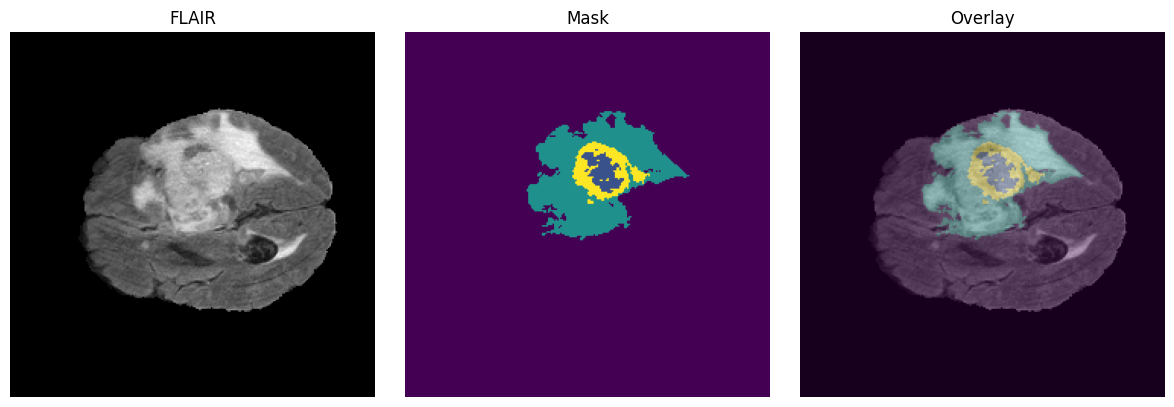

Unique mask values: [0. 1. 2. 4.]


In [10]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# pick one subject with non-empty seg
good = None
for p in train_subjects:
    sid = p.name
    seg = p / f"{sid}_seg.nii"
    if seg.exists() and seg.stat().st_size > 0:
        good = p
        break

print("Chosen subject:", good)

sid = good.name
flair = nib.load(str(good / f"{sid}_flair.nii")).get_fdata()
seg   = nib.load(str(good / f"{sid}_seg.nii")).get_fdata()

# pick slice with tumor
tumor_slices = np.where(seg.reshape(-1, seg.shape[-1]).max(axis=0) > 0)[0]
z = int(tumor_slices[len(tumor_slices)//2]) if len(tumor_slices)>0 else seg.shape[-1]//2

img = flair[:,:,z]
msk = seg[:,:,z]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img, cmap="gray"); plt.title("FLAIR"); plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(msk, vmin=0, vmax=4); plt.title("Mask"); plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(img, cmap="gray")
plt.imshow(msk, alpha=0.35, vmin=0, vmax=4)
plt.title("Overlay"); plt.axis("off")
plt.tight_layout()
plt.show()

print("Unique mask values:", np.unique(msk))


## 11. Data Readiness Summary: Initial Checklist

In [11]:
summary = {
    "CXR_csv_rows": len(cxr_df),
    "CXR_png_found": len(img_paths),
    "HAM_rows": len(ham_df),
    "HAM_jpg_found": len(ham_imgs),
    "BraTS_train_subjects": len(train_subjects),
    "BraTS_val_subjects": len(val_subjects),
}

pd.DataFrame([summary])


,CXR_csv_rows,CXR_png_found,HAM_rows,HAM_jpg_found,BraTS_train_subjects,BraTS_val_subjects
0,112120,112120,10015,20030,369,125


## 12. [Critical] GPU Availability & Activation

In [12]:
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("⚠️ You are on CPU. Enable GPU: Kaggle Settings → Accelerator → GPU (T4) → Restart session")


CUDA available: True
GPU: Tesla T4


## 13. ChestX-ray14: Validate Train/Test Split (Official Lists)

In [13]:
train_names = set(Path(train_list).read_text().strip().splitlines())
test_names  = set(Path(test_list).read_text().strip().splitlines())

print("train_list count:", len(train_names))
print("test_list  count:", len(test_names))
print("overlap (should be 0):", len(train_names & test_names))

# coverage vs csv
csv_names = set(cxr_df["Image Index"].astype(str).tolist())
print("train names in csv:", len(train_names & csv_names))
print("test names in csv :", len(test_names & csv_names))
print("csv names not in lists:", len(csv_names - train_names - test_names))


train_list count: 86524
test_list  count: 25596
overlap (should be 0): 0
train names in csv: 86524
test names in csv : 25596
csv names not in lists: 0


## 14. ChestX-ray14: Create Split Column & Stratified Statistics

In [14]:
cxr_df2 = cxr_df.copy()

def get_split(name):
    if name in train_names: return "train"
    if name in test_names:  return "test"
    return "other"

cxr_df2["split"] = cxr_df2["Image Index"].astype(str).map(get_split)

display(cxr_df2["split"].value_counts())

def count_labels(df):
    labs = df["Finding Labels"].fillna("No Finding").astype(str).str.split("|")
    c = {}
    for L in labs:
        for x in L:
            c[x] = c.get(x, 0) + 1
    return pd.Series(c).sort_values(ascending=False)

train_counts = count_labels(cxr_df2[cxr_df2["split"]=="train"])
test_counts  = count_labels(cxr_df2[cxr_df2["split"]=="test"])

display(pd.DataFrame({"train": train_counts, "test": test_counts}).fillna(0).astype(int).head(15))


split
train    86524
test     25596
Name: count, dtype: int64

,train,test
Atelectasis,8280,3279
Cardiomegaly,1707,1069
Consolidation,2852,1815
Edema,1378,925
Effusion,8659,4658
Emphysema,1423,1093
Fibrosis,1251,435
Hernia,141,86
Infiltration,13782,6112
Mass,4034,1748


## 15. [Critical] ChestX-ray14: Check Patient ID Leakage

In [15]:
tr_pat = set(cxr_df2.loc[cxr_df2["split"]=="train","Patient ID"].astype(int))
te_pat = set(cxr_df2.loc[cxr_df2["split"]=="test","Patient ID"].astype(int))

overlap_pat = tr_pat & te_pat
print("Train patients:", len(tr_pat))
print("Test  patients:", len(te_pat))
print("Patient overlap (leakage risk):", len(overlap_pat))


Train patients: 28008
Test  patients: 2797
Patient overlap (leakage risk): 0


## 16. HAM10000: Verify Lesion-Level Duplication

In [16]:
print("Unique lesion_id:", ham_df["lesion_id"].nunique())
print("Images per lesion (top 10):")
display(ham_df["lesion_id"].value_counts().head(10))


Unique lesion_id: 7470
Images per lesion (top 10):


lesion_id
HAM_0003789    6
HAM_0005263    6
HAM_0000835    6
HAM_0001863    6
HAM_0000893    5
HAM_0007427    5
HAM_0007343    5
HAM_0002364    5
HAM_0007367    5
HAM_0000889    4
Name: count, dtype: int64

## 17. HAM10000: Build Professional Lesion-Level Split

In [17]:
from sklearn.model_selection import train_test_split

lesions = ham_df["lesion_id"].unique()
tr_les, te_les = train_test_split(lesions, test_size=0.15, random_state=42)
tr_les, va_les = train_test_split(tr_les, test_size=0.10, random_state=42)

def ham_split(lesion_id):
    if lesion_id in te_les: return "test"
    if lesion_id in va_les: return "val"
    return "train"

ham_df2 = ham_df.copy()
ham_df2["split"] = ham_df2["lesion_id"].map(ham_split)

display(ham_df2["split"].value_counts())
display(pd.crosstab(ham_df2["dx"], ham_df2["split"]))


split
train    7614
test     1543
val       858
Name: count, dtype: int64

split,test,train,val
dx,,,
akiec,52,257,18
bcc,94,375,45
bkl,180,822,97
df,29,83,3
mel,176,860,77
nv,983,5118,604
vasc,29,99,14


## 18. BraTS2020: Detect Corrupted & Empty Segmentation Files

In [18]:
empty_seg = []
missing_any = []
for p in train_subjects:
    sid = p.name
    flair = p / f"{sid}_flair.nii"
    t1ce  = p / f"{sid}_t1ce.nii"
    t2    = p / f"{sid}_t2.nii"
    seg   = p / f"{sid}_seg.nii"

    if not (flair.exists() and t1ce.exists() and t2.exists() and seg.exists()):
        missing_any.append(sid)
    elif seg.stat().st_size == 0:
        empty_seg.append(sid)

print("Missing any modality:", len(missing_any))
print("Empty seg files:", len(empty_seg))
print("Example empty seg:", empty_seg[:5])


Missing any modality: 0
Empty seg files: 1
Example empty seg: ['BraTS20_Training_355']


## 19. [Critical] BraTS2020: Tumor Slice Distribution Analysis

Subjects counted: 368
Tumor slices stats: min/median/max = 23 68 102


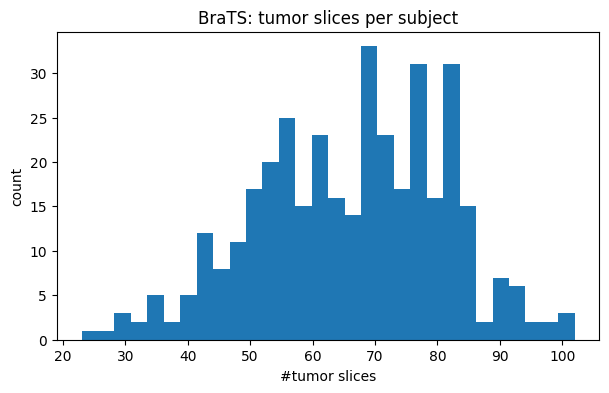

In [19]:
import nibabel as nib
import numpy as np

tumor_slice_counts = []
for p in train_subjects:
    sid = p.name
    segp = p / f"{sid}_seg.nii"
    if not segp.exists() or segp.stat().st_size == 0:
        continue
    seg = nib.load(str(segp)).get_fdata()
    tumor_slices = np.where(seg.reshape(-1, seg.shape[-1]).max(axis=0) > 0)[0]
    tumor_slice_counts.append(len(tumor_slices))

tumor_slice_counts = np.array(tumor_slice_counts)
print("Subjects counted:", len(tumor_slice_counts))
print("Tumor slices stats: min/median/max =", int(tumor_slice_counts.min()), int(np.median(tumor_slice_counts)), int(tumor_slice_counts.max()))

plt.figure(figsize=(7,4))
plt.hist(tumor_slice_counts, bins=30)
plt.title("BraTS: tumor slices per subject")
plt.xlabel("#tumor slices")
plt.ylabel("count")
plt.show()


## 20. Final Data Readiness Report

In [20]:
final_summary = {
    "CXR_images_found": len(img_paths),
    "CXR_rows_csv": len(cxr_df),
    "HAM_images_found": len(ham_imgs),
    "HAM_rows_meta": len(ham_df),
    "BraTS_train_subjects": len(train_subjects),
    "BraTS_val_subjects": len(val_subjects),
}

pd.DataFrame([final_summary])


,CXR_images_found,CXR_rows_csv,HAM_images_found,HAM_rows_meta,BraTS_train_subjects,BraTS_val_subjects
0,112120,112120,20030,10015,369,125
